In [1]:
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [470]:
# 读取数据
df = pd.read_csv('~/Desktop/EURUSD_M5_201401012300_201804301655.csv', 
                 parse_dates=True,sep='\t')
df.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2014.01.01,23:00:00,1.37550,1.37552,1.37520,1.37533,134,0,101
1,2014.01.01,23:05:00,1.37532,1.37581,1.37517,1.37517,266,0,70
2,2014.01.01,23:10:00,1.37517,1.37574,1.37372,1.37467,524,0,35
3,2014.01.01,23:15:00,1.37464,1.37499,1.37448,1.37496,114,0,70
4,2014.01.01,23:20:00,1.37496,1.37592,1.37482,1.37488,86,0,92


In [471]:
# 处理时间
df['DATETIME'] = df['<DATE>'].map(lambda date: '-'.join(date.split('.'))) + ' ' + df['<TIME>']
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.index = df['DATETIME']
df = df.drop(['DATETIME','<DATE>', '<TIME>'], axis = 1)
df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
DATETIME,,,,,,,
2014-01-01 23:00:00,1.37550,1.37552,1.37520,1.37533,134,0,101
2014-01-01 23:05:00,1.37532,1.37581,1.37517,1.37517,266,0,70
2014-01-01 23:10:00,1.37517,1.37574,1.37372,1.37467,524,0,35
2014-01-01 23:15:00,1.37464,1.37499,1.37448,1.37496,114,0,70
2014-01-01 23:20:00,1.37496,1.37592,1.37482,1.37488,86,0,92


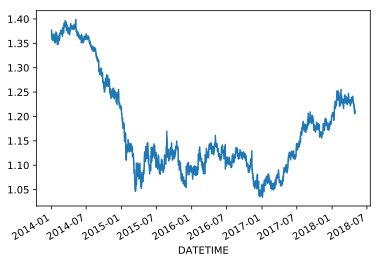

In [472]:
# 取close价格为这一时刻的价格
price = df['<CLOSE>']
price.plot()

# 得到两种指标

In [473]:
# 计算EMA
ema = talib.EMA(price, timeperiod=20)

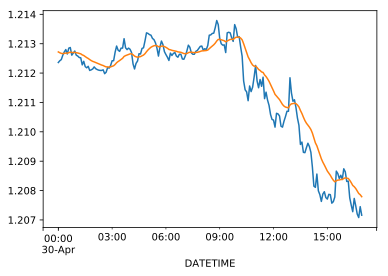

In [474]:
price['20180430':].plot()
ema['20180430':].plot()

In [475]:
# 计算MACD
# fastperiod= 12, slowperiod= 26, signalperiod= 9 default
macd, macdsignal, macdhist = talib.MACD(price)

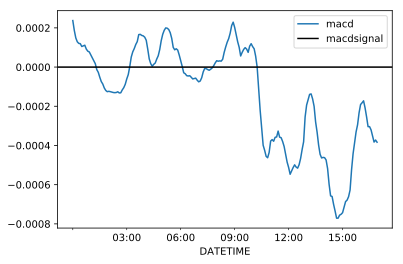

In [476]:
macd['20180430':].plot()
# macdsignal['20180430':].plot()
# macdhist['20180430':].plot()
plt.axhline(0, color='k', linestyle='solid')
plt.xticks([])
plt.legend(['macd','macdsignal','macdhist'])

In [477]:
df['ATR'] = talib.ATR(df['<HIGH>'],df['<LOW>'],df['<CLOSE>'], timeperiod=30)

In [478]:
df['ATR'].tail()

DATETIME
2018-04-30 16:35:00    0.000524
2018-04-30 16:40:00    0.000525
2018-04-30 16:45:00    0.000524
2018-04-30 16:50:00    0.000523
2018-04-30 16:55:00    0.000530
Name: ATR, dtype: float64

# 产生转换信号

In [479]:
def produce_signal(seq, difffunc):
    return (difffunc(seq)==True) & (difffunc(seq.shift(1))==False)

In [483]:
cross_above_ema = produce_signal(price-ema, lambda i: i>0)
cross_below_ema = produce_signal(price-ema, lambda i: i<0)
macd_change_pos = produce_signal(macd, lambda i: i>0)
macd_change_neg = produce_signal(macd, lambda i: i<0)

In [484]:
price[cross_above_ema].tail()

DATETIME
2018-04-30 09:50:00    1.21365
2018-04-30 10:05:00    1.21324
2018-04-30 11:00:00    1.21226
2018-04-30 12:55:00    1.21184
2018-04-30 15:30:00    1.20866
Name: <CLOSE>, dtype: float64

In [485]:
price[macd_change_pos].tail()

DATETIME
2018-04-27 13:25:00    1.20836
2018-04-27 16:10:00    1.20862
2018-04-27 20:55:00    1.21052
2018-04-30 03:10:00    1.21271
2018-04-30 07:50:00    1.21284
Name: <CLOSE>, dtype: float64

# 计算入市信号优势

In [486]:
df['iter'] = np.arange(price.size)

In [487]:
def pricesAfterSignal(singals, estimate, days=50):
    indexs = df[singals]['iter']

    def mapf(i):
        list = price.iloc[i:i+days]
        list.index = np.arange(list.size)
        return estimate(list, df['ATR'].iloc[i])

    return indexs.map(mapf) # [mapf(33) for tt in indexs]

In [488]:
def MFE(list, atr):
    return (list.max()-list[0])/atr
def MAE(list, atr):
    return (list[0] - list.min())/atr

In [489]:
def ATR(singals, days):
    return pricesAfterSignal(singals, MFE, days).mean()/ pricesAfterSignal(singals, MAE, days).mean()

In [490]:
def drawATR(singals, lrange=range(2, 100, 2)):
    a = []
#     lrange = range(2, 100, 2) # range(2, 60, 2)
    for i in lrange:
        a.append(ATR(singals, i))
    data = pd.Series(a, index=lrange)
    return data

# 测量MACD反转 作为入市信号

In [491]:
macd_change_pos_data = drawATR(macd_change_pos)
macd_change_pos_data.plot()

KeyboardInterrupt: 

In [ ]:
(macd_change_pos_data.idxmax(),macd_change_pos_data.max())

In [ ]:
(macd_change_pos_data.idxmin(),macd_change_pos_data.min())

In [ ]:
(macd_change_pos_data[10:].idxmin(),macd_change_pos_data[10:].min())

> **macd 反转单独使用时 毫无优势**
> 从图上可以看出 MACD 反转信号通常太迟了 发生反转时一般是近期的最高点 适合做超短线时反向用

# 测量上穿EMA 作为入市信号

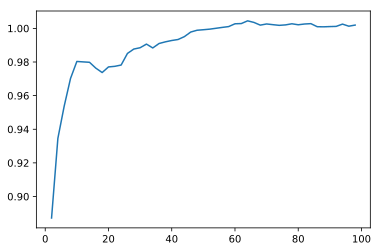

In [136]:
cross_above_ema_data = drawATR(cross_above_ema)
cross_above_ema_data.plot()

In [138]:
(cross_above_ema_data.idxmax(),cross_above_ema_data.max())

(64, 1.0044774022470289)

In [146]:
cross_above_ema_data2 = drawATR(cross_above_ema, range(100, 200, 10))

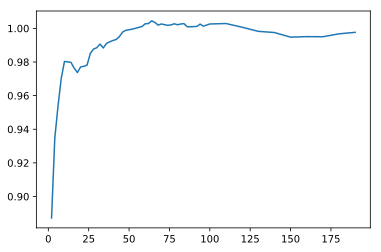

In [150]:
cross_above_ema_data.append(cross_above_ema_data2).plot()

In [152]:
cross_above_ema_data.head()

2     0.887210
4     0.934577
6     0.953780
8     0.970224
10    0.980321
dtype: float64

> ** 和上面的情况一样 **
> 单独使用只能在 短线 交易中，反向使用

当然这只是在只看`E-RATIO`一个参数的情况下

# 联合两个信号

In [494]:
indexs = df[macd_change_pos]['iter']

def filterf(i):
    return np.any([
        cross_above_ema[i-0],
        cross_above_ema[i-1],
        cross_above_ema[i-2],
        cross_above_ema[i-3],
#         cross_above_ema[i-4],
#         cross_above_ema[i-5],
    ])

long = indexs.where(indexs.map(filterf)).dropna().map(lambda t: int(t))

long_signal = price.map(lambda i: False)
for item in long:
    long_signal[item] = True

In [ ]:
buys_data = drawATR(long_signal, range(400, 800, 20))
buys_data.plot()

In [395]:
(buys_data.idxmax(), buys_data.max())

(10, 0.9726473358307701)

In [396]:
(buys_data.idxmin(), buys_data.min())

(170, 0.8208000961764934)

In [384]:
(macd_change_pos[macd_change_pos].size, long_signal[long_signal].size)

(908, 388)

In [385]:
price.size

22425

In [495]:
long['20180425':'20180430'].index

DatetimeIndex(['2018-04-25 02:10:00', '2018-04-25 06:25:00',
               '2018-04-25 16:45:00', '2018-04-26 01:55:00',
               '2018-04-26 06:10:00', '2018-04-26 08:45:00',
               '2018-04-26 09:35:00', '2018-04-26 12:05:00',
               '2018-04-26 15:45:00', '2018-04-27 01:00:00',
               '2018-04-27 03:50:00', '2018-04-27 04:55:00',
               '2018-04-27 13:25:00', '2018-04-27 20:55:00',
               '2018-04-30 03:10:00', '2018-04-30 07:50:00'],
              dtype='datetime64[ns]', name='DATETIME', freq=None)

# 交易